In [83]:
import os
new_directory = '/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/'
os.chdir(new_directory)

import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import yaml

In [91]:
def load_data_to_train(): 
    data_path = ('data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_IMPUTED_BY_CLASS_6PP.npy.gz')
    print('Loading from:\n', data_path)
    with gzip.open(data_path, 'rb') as f:
        np_data = np.load(f, allow_pickle=True)
    return np_data.item()['meta'], np_data.item()['lcs'], np_data

def plot_single_phased_lc(lc_real, cls='RR Lyrae', ID='EXAMPLE', period=1):
    """
    Creates a single light curve plot, phased over two cycles, with real data,
    starting from the phase of the maximum magnitude value.

    Parameters
    ----------
    lc_real : numpy array or DataFrame
        Real light curve data to be plotted.
    cls : string, optional
        Label to be displayed as legend.
    ID : string, optional
        Identifier for the plot, used in title and filename.
    period : float, optional
        Period of the light curve, used to calculate the phase.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(7, 4))

    # Identify the time of maximum magnitude
    max_mag_time = lc_real.loc[lc_real['magnitude'].idxmax(), 'time']

    # Calculate the phase, ensuring it starts from the maximum magnitude
    phased_time = ((lc_real['time'] - max_mag_time) / period) % 1
    lc_real['phased_time'] = phased_time

    # Sort by phased time for plotting continuity
    lc_real_sorted = lc_real.sort_values('phased_time')

    # Extend the phase and magnitude for two cycles
    phased_time_extended = np.concatenate([lc_real_sorted['phased_time'], 
                                           lc_real_sorted['phased_time'] + 1])
    
    magnitude_extended = np.concatenate([lc_real_sorted['magnitude'], 
                                         lc_real_sorted['magnitude']])
    
    ax.errorbar(phased_time_extended, magnitude_extended, fmt='.', c='gray', 
                alpha=0.5, label=cls)
    
    ax.set_xlabel('Phase', fontsize=15)
    ax.set_ylabel('Magnitude', fontsize=15)
    
    ax.invert_yaxis()
    ax.legend(loc='lower left')
    ax.set_title(ID)
    plt.tight_layout()

    plt.savefig(f'{ID}_lc_phased.png')  # Save the figure
    plt.show()

def plot_single_lc(lc_real, cls='RR Lyrae', ID='EXAMPLE', errorbar_color='blue'):
    """
    Creates a single light curve plot with real data, displaying photometric errors in a specified color.

    Parameters
    ----------
    lc_real : numpy array or DataFrame
        Real light curve data to be plotted. Expected to have 'time', 'magnitude', and 'magnitude_error' columns.
    cls : string, optional
        Label to be displayed as legend.
    ID : string, optional
        Identifier for the plot, used in title and filename.
    errorbar_color : string, optional
        Color for the error bars.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(7, 4))
    
    # Plotting the light curve with error bars in specified color
    ax.errorbar(lc_real['time'], lc_real['magnitude'], yerr=lc_real['error'],
                fmt='.', c='gray', ecolor=errorbar_color, alpha=0.5, label=cls)

    ax.set_xlabel('Time (MJD)', fontsize=15)  # Modified Julian Date for time axis
    ax.set_ylabel('Magnitude', fontsize=15)
    
    ax.invert_yaxis()  # Magnitude is usually plotted in reverse
    plt.title(ID)
    plt.tight_layout()

    plt.savefig(f'{ID}_lc.png')  # Save the figure before showing it
    plt.show()



In [92]:
with open('src/configuration/paths.yaml', 'r') as file:
    YAML_FILE = yaml.safe_load(file)

PATHS =YAML_FILE['paths']
PATH_LIGHT_CURVES_OGLE = PATHS['PATH_LIGHT_CURVES_OGLE']
PATH_FEATURES_TRAIN = PATHS['PATH_FEATURES_TRAIN']
PATH_FEATURES_TEST = PATHS['PATH_FEATURES_TEST']


lc_train = pd.read_table(PATH_FEATURES_TRAIN, sep= ',')
new_cols = lc_train.ID.str.split("-", n = 3, expand = True)
new_cols.columns = ['survey', 'field', 'class', 'number']
lc_train = pd.concat([new_cols, lc_train], axis=1)


lc_test = pd.read_table(PATH_FEATURES_TEST, sep= ',')
new_cols = lc_test.ID.str.split("-", n = 3, expand = True)
new_cols.columns = ['survey', 'field', 'class', 'number']
lc_test = pd.concat([new_cols, lc_test], axis=1)


lc_train = pd.concat([lc_train, lc_test])


In [93]:
meta, lcs, np_data = load_data_to_train()

Loading from:
 data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_IMPUTED_BY_CLASS_6PP.npy.gz


In [95]:
meta.columns

Index(['OGLE_id', 'Type', '[Fe/H]_J95', 'teff_val', 'Period', 'abs_Gmag',
       'radius_val', 'logg'],
      dtype='object')

| Type  | P (days) | T<sub>eff</sub> (K) | [Fe/H] (dex) | Abs. mag. (g band) | r (R<sub>⊙</sub>) | log g (dex) |
|-------|----------|---------------------|--------------|--------------------|------------------|-------------|
| CEP   | 3.78     | 5,553               | -0.95        | 2.94               | 2.34             | 3.69        |
| DCST  | 0.07     | 6,002               | -3.61        | 6.07               | 0.50             | 4.82        |
| ECL   | 1.42     | 4,769               | -1.79        | 6.76               | 0.58             | 4.60        |
| LPV   | 308.96   | 3,827               | 0.12         | -2.38              | 100.48           | 0.67        |
| RRLYR | 0.45     | 5,431               | -1.67        | 5.80               | 0.73             | 4.50        |


Int64Index([9550], dtype='int64')


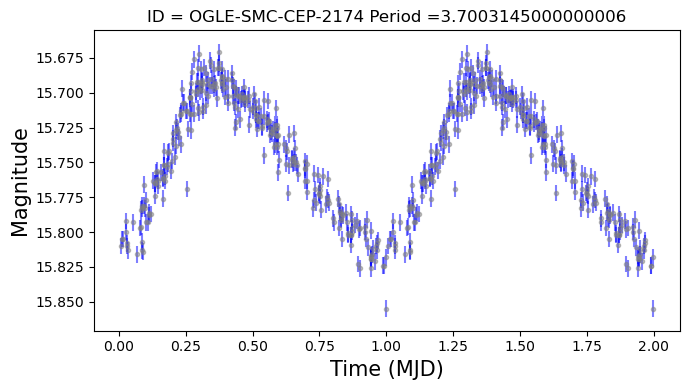

In [221]:
meta[(meta.Type=='CEP') &  (meta.Period > np.log10(3.7)) & (meta.Period < np.log10(3.8)) 
        & (meta.teff_val < np.log10(5800)) & (meta.teff_val > np.log10(5300)) 
        & (meta.abs_Gmag < 4) & (meta.abs_Gmag > 2)]

lc, lc_id_to_title = ('OGLE-SMC-CEP-2174.dat', 'OGLE-SMC-CEP-2174')
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 6.4)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
        & (meta.logg < 5.0) & (meta.logg > 4.4) 
        & (meta['[Fe/H]_J95'] < -1.5) & (meta['[Fe/H]_J95'] > -2)
})

p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='CEP', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [253]:
np.log10(3400)


3.531478917042255

Int64Index([50113], dtype='int64')


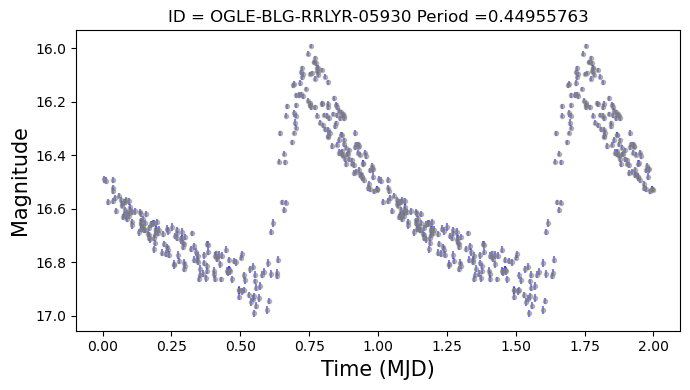

In [245]:
lc, lc_id_to_title = ('OGLE-BLG-RRLYR-05930.dat', 'OGLE-BLG-RRLYR-05930')
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='CEP', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [277]:
meta[(meta.Type=='LPV')].radius_val.max()

2.879933826910855

/home/franciscoperez/anaconda3/envs/cnnpelsvae/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


Int64Index([45706], dtype='int64')
(600, 3)


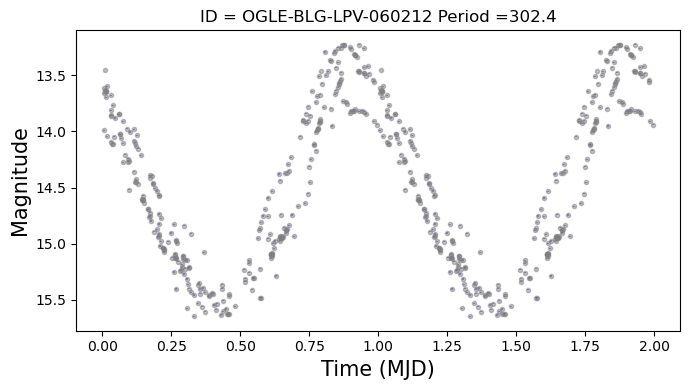

In [296]:
meta[(meta.Type=='LPV') &  (meta.Period > np.log10(300)) & (meta.Period < np.log10(340)) 
        & (meta['[Fe/H]_J95'] < 1) & (meta['[Fe/H]_J95'] > -.5)
        & (meta.teff_val < np.log10(4000)) & (meta.teff_val > np.log10(3500)) 
        & (meta.abs_Gmag < -2) & (meta.abs_Gmag > -3)
        & (meta.radius_val < np.log10(120)) & (meta.teff_val > np.log10(80)) 
         & (meta.logg < 0.7) & (meta.logg > 0.65)]

lc, lc_id_to_title = ('OGLE-BLG-LPV-060212.dat', 'OGLE-BLG-LPV-060212')
meta[meta.OGLE_id==lc_id_to_title].drop_duplicates(subset=['OGLE_id'], inplace=True)
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

print(lcu.shape)
p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='LPV', ID='ID = '+lc_id_to_title+' Period ='+str(p))

In [314]:
meta[(meta.Type=='ECL') &  (meta.Period > np.log10(1.2)) & (meta.Period < np.log10(1.6))
        & (meta.teff_val < np.log10(5000)) & (meta.teff_val > np.log10(4600)) 
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 6.4)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
         & (meta.logg < 5.0) & (meta.logg > 4.4) 
         & (meta['[Fe/H]_J95'] < -1.5) & (meta['[Fe/H]_J95'] > -2)]

,OGLE_id,Type,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
23308,OGLE-BLG-ECL-245076,ECL,-1.5792,3.698268,0.198867,6.8713,-0.293282,4.7717


/home/franciscoperez/anaconda3/envs/cnnpelsvae/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


Int64Index([23308], dtype='int64')
(600, 3)


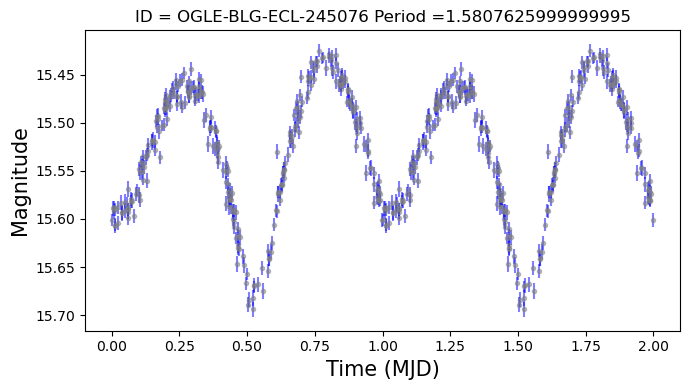

In [313]:
meta[(meta.Type=='ECL') &  (meta.Period > np.log10(1.2)) & (meta.Period < np.log10(1.6))
        & (meta.teff_val < np.log10(5000)) & (meta.teff_val > np.log10(4600)) 
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 6.4)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
        & (meta.logg < 5.0) & (meta.logg > 4.4) 
        & (meta['[Fe/H]_J95'] < -1.5) & (meta['[Fe/H]_J95'] > -2)]


lc, lc_id_to_title = ('OGLE-BLG-ECL-245076.dat', 'OGLE-BLG-ECL-245076')
meta[meta.OGLE_id==lc_id_to_title].drop_duplicates(subset=['OGLE_id'], inplace=True)
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

print(lcu.shape)
p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='LPV', ID='ID = '+lc_id_to_title+' Period ='+str(p))

                 OGLE_id  Type  [Fe/H]_J95  teff_val    Period  abs_Gmag  \
14796  OGLE-GD-DSCT-0022  DSCT     -3.1688  3.783063 -0.956404    5.4374   
14797  OGLE-GD-DSCT-0032  DSCT     -3.4426  3.746492 -1.082435    5.9138   
14856  OGLE-GD-DSCT-0029  DSCT     -2.6622  3.754194 -1.211634    5.8807   

       radius_val    logg  
14796   -0.178552  4.6720  
14797   -0.201142  4.6510  
14856   -0.210067  4.6694  
Int64Index([14856, 14880, 14883, 14905, 14906, 14910, 14913, 14946, 14996,
            15087,
            ...
            19377, 19411, 19465, 19501, 19515, 19530, 19535, 19673, 19675,
            19694],
           dtype='int64', length=105)
(63000, 3)


/home/franciscoperez/anaconda3/envs/cnnpelsvae/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


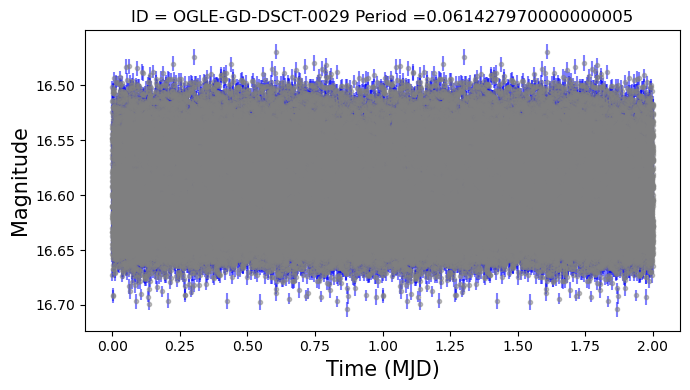

In [329]:
print(meta[(meta.Type=='DSCT') &  (meta.Period > np.log10(0.05)) & (meta.Period < np.log10(0.2))
        & (meta.teff_val < np.log10(6500)) & (meta.teff_val > np.log10(5500)) 
        & (meta['[Fe/H]_J95'] < -2.5) & (meta['[Fe/H]_J95'] > -4)        
        & (meta.abs_Gmag < 7) & (meta.abs_Gmag > 5)
        & (meta.radius_val < np.log10(0.7)) & (meta.teff_val > np.log10(0.4)) 
         & (meta.logg < 5.0) & (meta.logg > 4.6) ].drop_duplicates())


lc, lc_id_to_title = ('OGLE-GD-DSCT-0029.dat', 'OGLE-GD-DSCT-0029')
meta[meta.OGLE_id==lc_id_to_title].drop_duplicates(subset=['OGLE_id'], inplace=True)
print(meta[meta.OGLE_id==lc_id_to_title].index)
# Extract time, magnitude, and error
time = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,0].flatten()
magnitude = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,1].flatten()
error = lcs[meta[meta.OGLE_id == lc_id_to_title].index][:,:,2].flatten()
# Create a DataFrame
lcu = pd.DataFrame({
    'time': time,
    'magnitude': magnitude,
    'error': error
})

print(lcu.shape)
p = np.power(10, meta[meta.OGLE_id==lc_id_to_title].Period.values[0])

plot_single_lc(lcu, cls='LPV', ID='ID = '+lc_id_to_title+' Period ='+str(p))